In [1]:
from sklearn.preprocessing import StandardScaler
import numpy as np
from numpy.linalg import norm
import pandas as pd
from sklearn import model_selection
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Import the boston dataset from sklearn
from sklearn.datasets import load_boston
boston = load_boston()

#Descriptive information about the boston dataset
print(boston.DESCR)

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

In [3]:
#Get information about the shape of the boston dataset
print(boston.data.shape)

(506, 13)


In [4]:
#Get column names for the boston dataset
print(boston.feature_names)

['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']


In [5]:
#Create a pandas dataframe for later use.
boston_df = pd.DataFrame(boston.data, columns=boston.feature_names)
boston_df['PRICE'] = boston.target
boston_df.head(5)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [6]:
#Split the dataset into training and test set.
X_train, X_test, y_train, y_test = model_selection.train_test_split(boston.data, boston.target, test_size = 0.20, random_state = 5)

In [7]:
#Function used to column standardize any given matrix
scalar = StandardScaler()
X_train = scalar.fit_transform(X_train)
X_test = scalar.transform(X_test)

In [8]:
print("Shape of the training data: ", X_train.shape)
print("Shape of the testing data: ", X_test.shape)

Shape of the training data:  (404, 13)
Shape of the testing data:  (102, 13)


In [9]:
#Make a new train dataframe containing X_train
train_df = pd.DataFrame(data = X_train, columns=boston.feature_names)
train_df['PRICE'] = list(y_train)

test_df = pd.DataFrame(data = X_test, columns=boston.feature_names)
test_df['PRICE'] = list(y_test)

train_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,-0.273810,-0.507766,-0.402012,-0.272888,-0.118484,-0.848834,0.963877,-0.022455,-0.636453,-0.583618,1.175619,-0.000302,0.835288,13.1
1,-0.404895,3.331365,-1.431888,3.664502,-1.314148,2.361809,-1.516597,0.999022,-0.981745,-1.231926,-2.202859,0.412907,-1.325495,50.0
2,8.073348,-0.507766,1.078157,-0.272888,1.112090,-0.478931,1.140549,-0.988813,1.665490,1.551633,0.810378,-3.849276,1.158196,8.8
3,-0.401406,-0.507766,0.161225,-0.272888,0.186977,-0.243407,0.317257,-0.752702,-0.981745,-0.785842,1.175619,0.428424,-0.483373,20.6
4,0.699954,-0.507766,1.078157,-0.272888,1.234274,0.166954,1.140549,-1.068474,1.665490,1.551633,0.810378,0.194665,1.114099,12.1


In [13]:
#This function is used to implement SGD from scratch. What this function does is that it takes a bunch of inputs like training data, learning rate, learning rate type etc and performs stochastic gradient decent 
#with a sample size of 10 to obtain the best value of the linear coefficients w and b. Just like as in SGDRegressor() I have implemented 'invscaling' and 'constant' learning rate. In case of 'constant', 
#the learning rate won't change across all the epochs. In case of 'invscaling', the learning rate will be reduced by a factor lr_rate / pow(epoch, power_epoch), similar to the implementation present in the SGD 
#Regressor. There are two ways to initialize the initial weights. We can either set them to be zero, or make them equal to some very small values selected from a random normal distribution. The approach that I have
#followed is to set them to zero. The other one is commented out. You can follow the later if you want to. Just uncomment the code.
def sgd_optimize(X_train, y_train, lr_rate, lr_rate_variation, n_epochs, power_epoch):
    w_coeff=np.random.randn(13,1) #Randomly initalizing weights
    b_coeff=np.random.randn(1,1)  #Randomly picking up intercept value.
    
    for epoch in range(1,n_epochs+1):
        sum_errors = 0 #Sum of squared loss.
        N = X_train.shape[0] #The variable N in the SGD equation.

        for i in range(N):
            batch_size = np.random.randint(0,N)  # random batch size for every iteration i.e k batch_size
            X_i = X_train[batch_size,:].reshape(1,X_train.shape[1])
            y_i = y_train[batch_size].reshape(1,1)

            y_pred = np.dot(X_i,w_coeff) + b_coeff                  #y_curr = WT.X + B
            loss = y_pred - y_i                                     #w_grad = (-2/N)*(X)*(y-(WT.X+B)) = (-2/N)*(X) * loss 
            sum_errors += loss**2                                   #b_grad = (-2/N)*(y-(WT.X+B)) = (-2/N) * loss

            w_grad = X_i.T.dot((y_pred - y_i))
            b_grad = (y_pred - y_i)
            w_coeff = w_coeff -(2/N)*lr_rate*(w_grad)
            b_coeff = b_coeff - (2/N)*lr_rate*(b_grad)

        print(epoch, sum_errors/N)

        if(lr_rate_variation=='invscaling'): #Implementing learning_rate 'invscaling' similar to that present in SGD Regressor.
            lr_rate = lr_rate / pow(epoch, power_epoch)
        else:
            pass

    return w_coeff, b_coeff

#This function is used to predict the class values given a test data.
def predict(X_test, w_coeff, b_coeff):
    X_test=np.array(X_test)
    y_pred =[]
    for i in range(0,len(X_test)):
        y=np.asscalar(np.dot(w_coeff,X_test[i]) + b_coeff) #Convert an array of size 1 to its scalar equivalent.
        y_pred.append(y)
    return np.array(y_pred)

#This function is used to compare the distribution of the actual values and predicted values.
#This will give us a generic idea if or not the predicted and actual values are close to each other.
def plot_distribution(y_test,y_pred):
    import seaborn as sns
    dataset=pd.DataFrame(y_test,columns=['Actual_Y'])
    dataset['Predcited_Y']=y_pred
    plt.figure(figsize=(12,12))
    sns.distplot(y_test, label = "Actual Y", color = 'red')
    sns.distplot(y_pred, label = "Predcited Y" , color = 'blue' )
    plt.legend()
    plt.show()
    
#This function is used to plot the scatter plot between actual and predicted y.
def plot_scatter(y_test,y_pred):
    plt.scatter(y_test,y_pred)
    plt.title('Scatter plot between Actual and Predicted Y.')
    plt.xlabel('Actual Y')
    plt.ylabel('Predicted Y')
    plt.grid(b=True, linewidth=0.5)
    plt.show()

    #Get the mean squared error between the predicted and the actual values.   
    mse=mean_squared_error(y_test,y_pred)
    print('Mean Squared Error between Actual and Predicted values: ',mse)
    return mse

#Plot a chart of predicted values Vs actual values.    
def plot_chart(y_test,y_pred):
    data=[y_test,y_pred]
    labels=["Actual Y","Predicted Y"]
    x_axes = np.arange(0,len(list(y_test)))
    color_map = ['red','blue']
    plt.figure(figsize=(30,5))
    for index in range(0,len(data)):
        plt.plot(x_axes, data[index], color=color_map[index], label=labels[index])
    plt.xlabel('Data Points')
    plt.title("Comparison between the predicted and actual values.")
    plt.legend()
    plt.show()    

In [15]:
#Get the optimal value of the w coefficients and b coefficients.
w_coeff_optimal, b_coeff_optimal = sgd_optimize(X_train, y_train, lr_rate=0.01, lr_rate_variation='constant', n_epochs=500, power_epoch=None)
weights_df = pd.DataFrame(w_coeff_optimal, columns=["SGD + Constant LR"])

1 [[600.27507122]]
2 [[528.81586062]]
3 [[519.34964579]]
4 [[514.01482383]]
5 [[487.60975213]]
6 [[459.41216351]]
7 [[431.9653136]]
8 [[454.33495961]]
9 [[419.00705924]]
10 [[407.00832836]]
11 [[389.82533133]]
12 [[362.83919032]]
13 [[333.94625275]]
14 [[318.88682507]]
15 [[343.94623754]]
16 [[301.87497092]]
17 [[286.03771298]]
18 [[299.22948263]]
19 [[274.57668192]]
20 [[311.61031138]]
21 [[284.37846208]]
22 [[260.44713702]]
23 [[255.58570921]]
24 [[255.88824185]]
25 [[218.13935822]]
26 [[189.35032994]]
27 [[212.57080382]]
28 [[188.32660928]]
29 [[197.4799543]]
30 [[173.07296093]]
31 [[190.41044686]]
32 [[176.70845391]]
33 [[168.28702926]]
34 [[177.88256143]]
35 [[184.43805885]]
36 [[152.74578384]]
37 [[155.62298527]]
38 [[158.85597061]]
39 [[166.24440583]]
40 [[138.93207449]]
41 [[115.45619261]]
42 [[154.53321913]]
43 [[125.51517927]]
44 [[116.95086681]]
45 [[112.93172162]]
46 [[103.62408292]]
47 [[104.80250237]]
48 [[99.26870916]]
49 [[91.63606779]]
50 [[93.63325975]]
51 [[111.35963

424 [[22.35687359]]
425 [[29.08957068]]
426 [[23.80490081]]
427 [[26.07250486]]
428 [[27.49358221]]
429 [[27.23009112]]
430 [[25.11640851]]
431 [[24.98245723]]
432 [[21.48050493]]
433 [[26.63298885]]
434 [[22.01474041]]
435 [[20.401665]]
436 [[27.54076871]]
437 [[23.53129616]]
438 [[23.90624465]]
439 [[22.65524741]]
440 [[26.54000395]]
441 [[22.27001007]]
442 [[23.36494624]]
443 [[24.73248595]]
444 [[26.28014075]]
445 [[18.79487956]]
446 [[26.33285318]]
447 [[17.7925397]]
448 [[23.20161365]]
449 [[27.03015311]]
450 [[30.42740411]]
451 [[26.11212135]]
452 [[22.77935167]]
453 [[23.48555768]]
454 [[28.15413112]]
455 [[20.23673596]]
456 [[20.49365777]]
457 [[25.11319972]]
458 [[26.27993241]]
459 [[24.76876904]]
460 [[21.81076763]]
461 [[16.89125528]]
462 [[22.52434036]]
463 [[28.99217481]]
464 [[24.8477803]]
465 [[23.49937835]]
466 [[19.73953507]]
467 [[24.25179072]]
468 [[23.19587799]]
469 [[22.74489536]]
470 [[22.19620238]]
471 [[25.56502979]]
472 [[24.80170884]]
473 [[18.53611816]]
474 

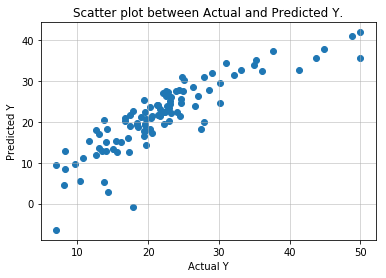

Mean Squared Error between Actual and Predicted values:  21.04382218800605


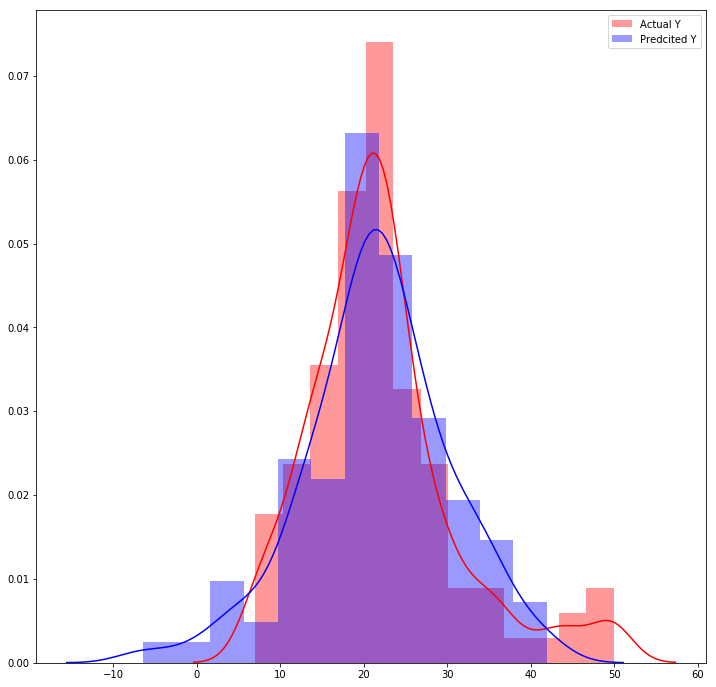

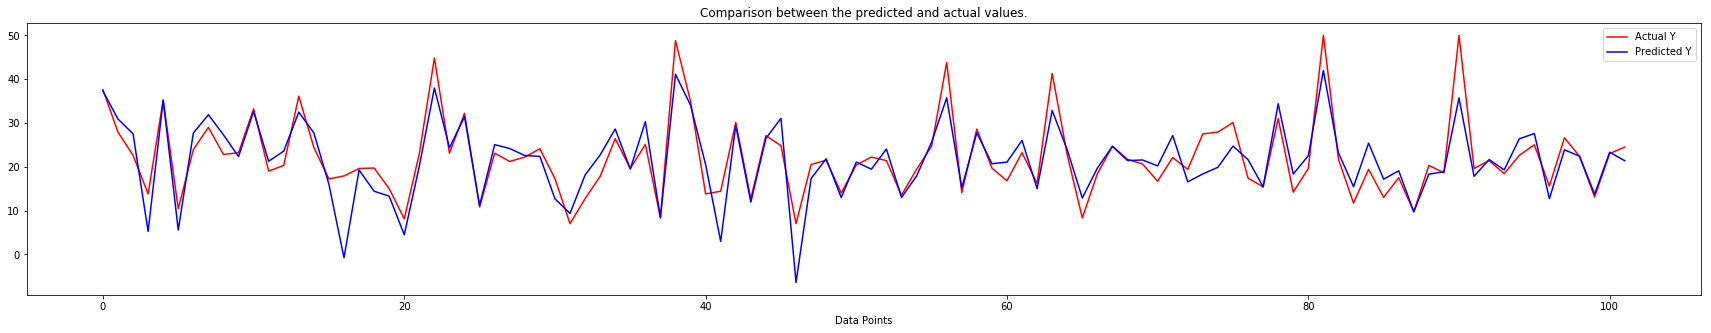

In [16]:
#Predict the class labels of the test set using the optimal values obtained from the previous step.
y_pred = predict(X_test, w_coeff_optimal.T, b_coeff_optimal)

#Draw the scatter plot
mse1=plot_scatter(y_test,y_pred)

#Plot the distribution of the actual and predicted values.
plot_distribution(y_test,y_pred)

#Plot a chart of predicted values Vs actual values.
plot_chart(y_test,y_pred)

In [17]:
#Get the optimal value of the w coefficients and b coefficients.
w_coeff_optimal, b_coeff_optimal = sgd_optimize(X_train, y_train, lr_rate=1, lr_rate_variation='invscaling', n_epochs=500, power_epoch=0.25)
weights_df["SGD + Variable LR"] = pd.DataFrame(w_coeff_optimal)

1 [[176.73663023]]
2 [[25.71911441]]
3 [[21.46201265]]
4 [[22.06362373]]
5 [[21.56747682]]
6 [[23.62738554]]
7 [[22.186398]]
8 [[26.74057011]]
9 [[20.53094677]]
10 [[21.31662036]]
11 [[24.02918818]]
12 [[21.32696999]]
13 [[25.69247079]]
14 [[26.65151223]]
15 [[22.18278805]]
16 [[22.17241191]]
17 [[24.27828791]]
18 [[17.75028604]]
19 [[21.71108948]]
20 [[21.82952368]]
21 [[21.2716441]]
22 [[23.44090725]]
23 [[23.89718107]]
24 [[22.99383668]]
25 [[23.37388389]]
26 [[26.12500931]]
27 [[21.61635378]]
28 [[20.69283704]]
29 [[23.27710976]]
30 [[22.62155422]]
31 [[24.47888606]]
32 [[21.76217587]]
33 [[20.91823564]]
34 [[24.13649729]]
35 [[27.42387817]]
36 [[22.02809644]]
37 [[19.06251118]]
38 [[20.64784356]]
39 [[18.5502331]]
40 [[23.87704912]]
41 [[24.29746109]]
42 [[18.83884916]]
43 [[17.76611982]]
44 [[20.61209552]]
45 [[22.60638934]]
46 [[21.63772296]]
47 [[22.02099139]]
48 [[19.78674671]]
49 [[22.84570929]]
50 [[24.23131874]]
51 [[24.10856421]]
52 [[27.50130405]]
53 [[21.08203986]]
54 [[

437 [[18.97280412]]
438 [[22.19648676]]
439 [[18.59075644]]
440 [[19.55399356]]
441 [[25.25153745]]
442 [[23.25258664]]
443 [[25.26848885]]
444 [[24.82624491]]
445 [[28.49130604]]
446 [[22.49250889]]
447 [[24.98626735]]
448 [[19.14864132]]
449 [[22.31643026]]
450 [[21.47574246]]
451 [[19.37939217]]
452 [[21.08812519]]
453 [[21.11139116]]
454 [[20.17961416]]
455 [[26.42535943]]
456 [[29.45961816]]
457 [[31.13056511]]
458 [[20.68103897]]
459 [[26.35697449]]
460 [[21.56500937]]
461 [[21.55760725]]
462 [[20.94784393]]
463 [[21.10126904]]
464 [[21.35232514]]
465 [[22.27950266]]
466 [[22.63081511]]
467 [[23.58160588]]
468 [[21.57906486]]
469 [[26.64418306]]
470 [[19.34553494]]
471 [[25.0561022]]
472 [[23.76816899]]
473 [[22.02937254]]
474 [[24.91916595]]
475 [[24.75114391]]
476 [[22.46832107]]
477 [[24.37338519]]
478 [[21.43832976]]
479 [[22.77660289]]
480 [[25.1210914]]
481 [[23.96839062]]
482 [[26.162042]]
483 [[22.34814299]]
484 [[23.6450541]]
485 [[22.1836338]]
486 [[24.09904456]]
487 [[

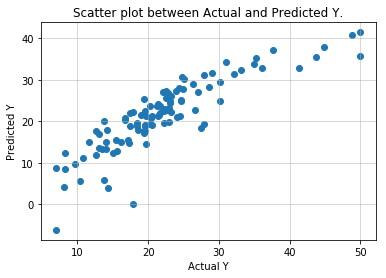

Mean Squared Error between Actual and Predicted values:  20.068886616934783


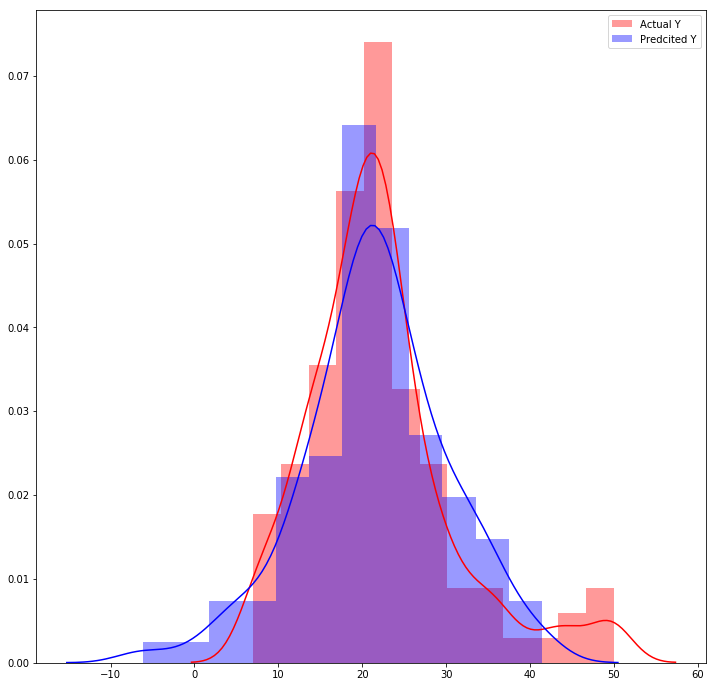

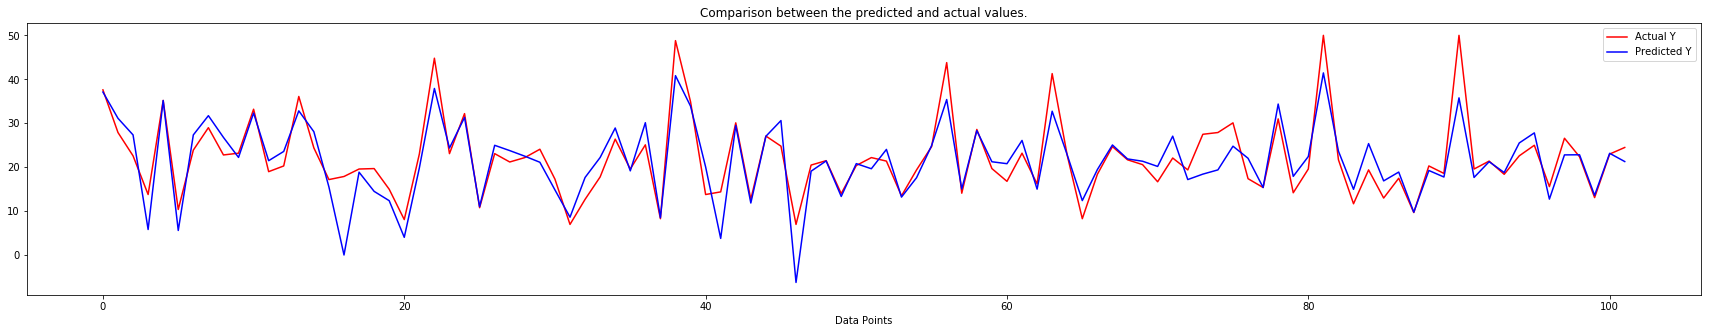

In [18]:
#Predict the class labels of the test set using the optimal values obtained from the previous step.
y_pred = predict(X_test, w_coeff_optimal.T, b_coeff_optimal)

#Draw the scatter plot
mse2=plot_scatter(y_test,y_pred)

#Plot the distribution of the actual and predicted values.
plot_distribution(y_test,y_pred)

#Plot a chart of predicted values Vs actual values.
plot_chart(y_test,y_pred)